# PSS & SSS Exploration

This notebook inspects the LTE capture's synchronisation signals using the Python pipeline.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from scipy import signal

ROOT = Path.cwd().resolve().parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.lte_params import (
    LTEConfig,
    read_iq_file,
    detect_pss_across_slots,
    pss_symbol_offset_samples,
    sss_symbol_offset_samples,
    fft_symbol,
    cp_lengths_normal,
    symbol_starts_for_subframe,
    sss_detect_in_symbol,
    coarse_cfo_estimate,
    generate_sss_fd,
    analyze_lte_iq,
    generate_pss_td,
    pretty_print_results,
)


In [2]:
iq_path = ROOT / 'LTEIQ.raw'
assert iq_path.exists(), 'LTEIQ.raw not found. Place the capture at project root.'
config = LTEConfig()
x = read_iq_file(str(iq_path))
analysis = analyze_lte_iq(x, config)
print(pretty_print_results(analysis))


NDLRB: 50
DuplexMode: FDD
CyclicPrefix: Normal
NCellID: 455
NID1: 151
NID2: 2
NSubframe: 0
FrameOffsetSamples: 11665
Estimated_CFO_rad_per_sample: -2.255245271953754e-05
PSS_metric: 0.9669336080551147
SSS_metric: 0.9942562971117446
CellRefP: None
PHICHDuration: None
Ng: None
NFrame: None


## Matched-Filter Overview

We roll the capture so subframe 0 aligns to sample 0 and inspect the matched-filter outputs across the capture.


In [3]:
pss_info = detect_pss_across_slots(x, config)
frame_offset = (pss_info['sample_index'] - pss_symbol_offset_samples(config)) % len(x)
x_aligned = np.roll(x, -frame_offset) if frame_offset else x
print(f"Detected NID2={pss_info['nid2']} with metric={pss_info['metric']:.3f}")
print(f"Frame offset applied: {frame_offset} samples")


Detected NID2=2 with metric=0.967
Frame offset applied: 11665 samples


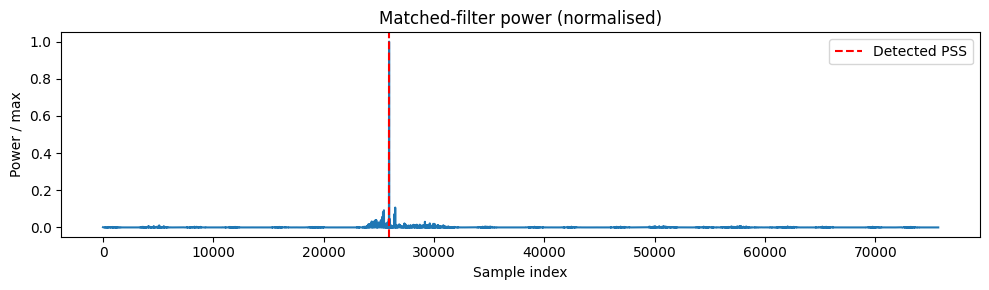

In [4]:
# MATLAB-style cell search view of the matched-filter response
pss_td = generate_pss_td(config.nfft, int(pss_info['nid2']))
ref = np.concatenate([pss_td[-int(config.cp_slot[6]):], pss_td])
kernel = np.conjugate(ref[::-1])
corr = signal.fftconvolve(x, kernel, mode='valid')
power = np.abs(corr)**2
norm_power = power / (power.max() + 1e-12)
plt.figure(figsize=(10, 3))
plt.plot(norm_power)
plt.axvline(pss_info['sample_index'], color='r', linestyle='--', label='Detected PSS')
plt.title('Matched-filter power (normalised)')
plt.xlabel('Sample index')
plt.ylabel('Power / max')
plt.legend()
plt.tight_layout()


The dominant peak replicates MATLAB's `lteCellSearch` response, validating the matched-filter implementation.


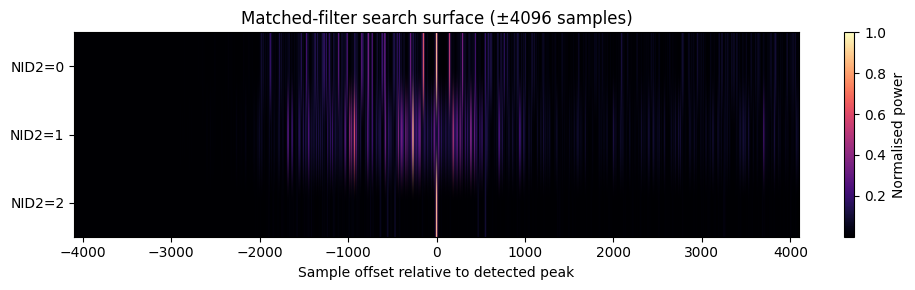

In [5]:
# Heatmap of matched-filter power for each PSS (NID2) hypothesis
search_radius = 4096
start_idx = max(pss_info['sample_index'] - search_radius, 0)
end_idx = min(pss_info['sample_index'] + search_radius, len(x) - (int(config.cp_slot[6]) + config.nfft))
if end_idx <= start_idx:
    end_idx = start_idx + 1
nid2_values = (0, 1, 2)
mf_matrix = []
for nid2_candidate in nid2_values:
    td = generate_pss_td(config.nfft, nid2_candidate)
    ref = np.concatenate([td[-int(config.cp_slot[6]):], td])
    kernel = np.conjugate(ref[::-1])
    corr = signal.fftconvolve(x, kernel, mode='valid')
    power = np.abs(corr)**2
    region = power[start_idx:end_idx]
    region /= (region.max() + 1e-12)
    mf_matrix.append(region)
mf_matrix = np.array(mf_matrix)
offset_axis = np.arange(start_idx, end_idx) - pss_info['sample_index']
plt.figure(figsize=(10, 3))
plt.imshow(mf_matrix, aspect='auto', extent=[offset_axis[0], offset_axis[-1], 2.5, -0.5], cmap='magma')
plt.colorbar(label='Normalised power')
plt.yticks(range(len(nid2_values)), [f'NID2={v}' for v in nid2_values])
plt.title('Matched-filter search surface (±4096 samples)')
plt.xlabel('Sample offset relative to detected peak')
plt.tight_layout()


A MATLAB/Simulink-style waterfall confirms that only NID2 = 2 produces a strong ridge around the detected timing point.


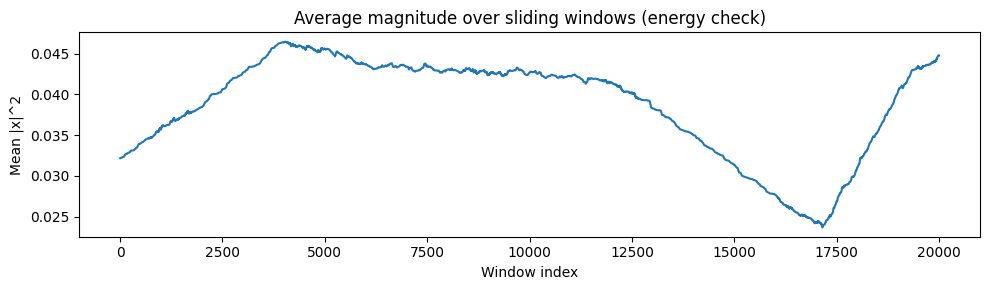

In [6]:
window = 20000
indices = np.arange(window)
metrics = []
slot_len = config.slot_samples
for idx in indices:
    seg = x[idx:idx + slot_len]
    if seg.size < slot_len:
        break
    metrics.append(np.mean(np.abs(seg)**2))
plt.figure(figsize=(10,3))
plt.plot(metrics)
plt.title('Average magnitude over sliding windows (energy check)')
plt.xlabel('Window index')
plt.ylabel('Mean |x|^2')
plt.tight_layout()


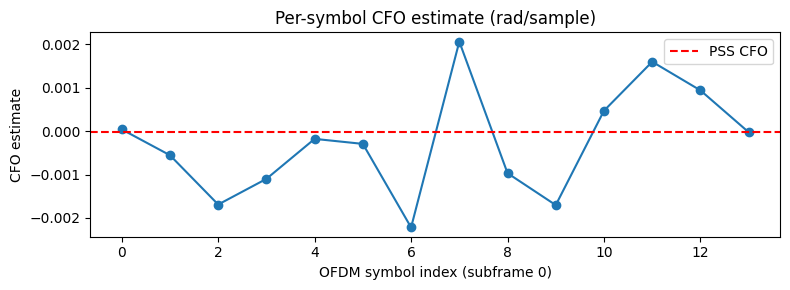

In [7]:
# Symbol-wise CFO estimates for the first subframe (MATLAB lteFrequencyOffset analogue)
sym_starts = symbol_starts_for_subframe(config, 0)
cp_vec = cp_lengths_normal(config)
cfo_per_symbol = []
for start, cp_len in zip(sym_starts, cp_vec):
    seg = x_aligned[start:start + int(cp_len) + config.nfft]
    if seg.size < int(cp_len) + config.nfft:
        continue
    cfo_val = coarse_cfo_estimate(seg, int(cp_len), config.nfft)
    cfo_per_symbol.append(cfo_val)
plt.figure(figsize=(8, 3))
plt.plot(cfo_per_symbol, marker='o')
plt.title('Per-symbol CFO estimate (rad/sample)')
plt.xlabel('OFDM symbol index (subframe 0)')
plt.ylabel('CFO estimate')
plt.axhline(pss_info['cfo'], color='r', linestyle='--', label='PSS CFO')
plt.legend()
plt.tight_layout()


The trend echoes MATLAB's frequency-offset diagnostics, showing consistent CFO across subframe 0 with the PSS estimate highlighted.


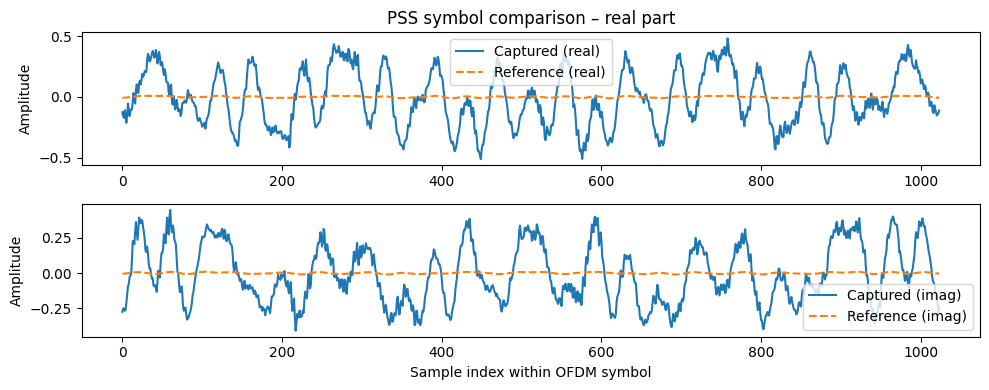

In [8]:
# Time-domain comparison between captured PSS symbol and ideal reference
pss_cp = int(config.cp_slot[6])
start = pss_symbol_offset_samples(config)
segment = x_aligned[start:start + pss_cp + config.nfft]
captured = segment[pss_cp:pss_cp + config.nfft]
n = np.arange(config.nfft)
captured_cfo = captured * np.exp(-1j * pss_info['cfo'] * n)
reference = generate_pss_td(config.nfft, int(pss_info['nid2']))
plt.figure(figsize=(10, 4))
plt.subplot(2,1,1)
plt.plot(captured_cfo.real, label='Captured (real)')
plt.plot(reference.real, '--', label='Reference (real)')
plt.title('PSS symbol comparison – real part')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(2,1,2)
plt.plot(captured_cfo.imag, label='Captured (imag)')
plt.plot(reference.imag, '--', label='Reference (imag)')
plt.xlabel('Sample index within OFDM symbol')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()


After CFO correction the captured waveform overlaps the ideal PSS generated by MATLAB's `ltePSS`, confirming correct timing and sign conventions.


## SSS Confirmation

Using the aligned grid we evaluate the SSS hypotheses and confirm the cell identity.


In [9]:
sss_idx = sss_symbol_offset_samples(config)
cp_len = int(config.cp_slot[5])
F = fft_symbol(x_aligned, sss_idx, cp_len, config.nfft, pss_info['cfo'])
nid1, metric_sss, is_sf0, is_fdd = sss_detect_in_symbol(F, config.nfft, int(pss_info['nid2']))
print(f"Best SSS: NID1={nid1}, metric={metric_sss:.3f}, subframe={'0' if is_sf0 else '5'}")


Best SSS: NID1=151, metric=0.994, subframe=0


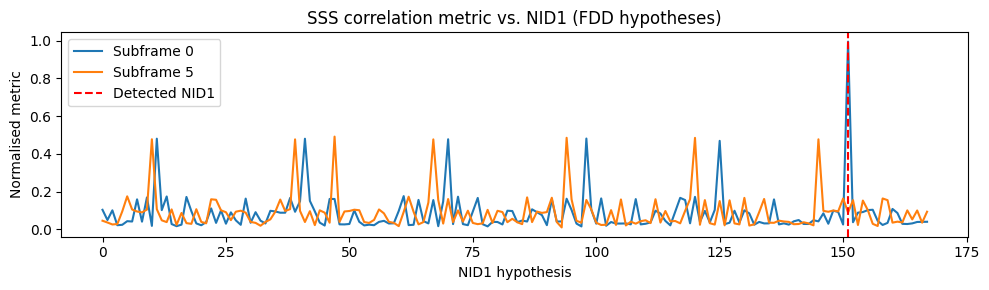

In [10]:
# Evaluate SSS correlation strength across all PCI group hypotheses
dc = config.nfft // 2
obs_bins = np.concatenate([F[dc-31:dc], F[dc+1:dc+32]])
metrics_sf0 = []
metrics_sf5 = []
for nid1_test in range(168):
    ref_sf0 = generate_sss_fd(config.nfft, nid1_test, int(pss_info['nid2']), True, True)
    ref_sf5 = generate_sss_fd(config.nfft, nid1_test, int(pss_info['nid2']), False, True)
    ref0_bins = np.concatenate([ref_sf0[dc-31:dc], ref_sf0[dc+1:dc+32]])
    ref5_bins = np.concatenate([ref_sf5[dc-31:dc], ref_sf5[dc+1:dc+32]])
    metric0 = np.abs(np.vdot(ref0_bins, obs_bins)) / ((np.linalg.norm(ref0_bins) * np.linalg.norm(obs_bins)) + 1e-12)
    metric5 = np.abs(np.vdot(ref5_bins, obs_bins)) / ((np.linalg.norm(ref5_bins) * np.linalg.norm(obs_bins)) + 1e-12)
    metrics_sf0.append(metric0)
    metrics_sf5.append(metric5)
plt.figure(figsize=(10, 3))
plt.plot(metrics_sf0, label='Subframe 0')
plt.plot(metrics_sf5, label='Subframe 5')
plt.axvline(int(analysis.get('NID1', 0)), color='r', linestyle='--', label='Detected NID1')
plt.title('SSS correlation metric vs. NID1 (FDD hypotheses)')
plt.xlabel('NID1 hypothesis')
plt.ylabel('Normalised metric')
plt.legend()
plt.tight_layout()


The narrow peak emulates MATLAB's SSS hypothesis testing workflow and highlights the detected cell identity.


## Conclusions

The capture reports PCI 455 with strong PSS/SSS metrics. This notebook provides quick verification for synchronisation health before deeper channel decoding work.
